# Продвинутое машинное обучение: ДЗ 1

## Часть I: О теореме Байеса

1. 
P(A) = 0.01 - вероятность иметь группу крови, как на месте преступлния <br>
P(B) = p - вероятность того, что подозреваемый виновен основываясь на других признаках (без учета крови)<br>
Прокурор оценил вероятность иметь другую группу крови у случайно взятого человека: $ P(\overline{A}) $= 1 - P(A) = 0.99<br>
Должен был оценить вероятность того, что подсудимый виновен, при условии, что у него группа крови как на месте преступления:
$ P(B|A) = \frac{P(A|B) * P(B)}{P(A|B) * P(B) + P(A|\overline{B}) * P(\overline{B})} = \frac{1 * p}{1 * p + 0.01 * (1 - p)} = \frac{100p}{99p + 1}$<br>
Эта вероятность значительно больше p (если p не равно 0 или 1), но все равно зависит от p (априорной)

2. 
Адвокат оценил вероятность быть убийцей для каждого из обладателя редкой группы крови, не учитывая, что подсудимый был уже задержан до определения группы у него, а значит по другим причинам<br>
Должен был оценить P(B|A), как в пункте выше

3. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime
from sklearn.linear_model import LinearRegression
import math
import matplotlib as mpl
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
figsize = (15,8)
%matplotlib inline

def pos_test(p1, p2):
    return ((1 - p1) * 0.01) / ((1 - p1) * 0.01 + p2 * 0.99)

def neg_test(p1, p2):
    return (p2 * 0.01) / ((1 - p1) * 0.99 + p2 * 0.01)

CONST_P = 0.05

In [2]:
p2 = np.linspace(0, CONST_P, 100)
var_p2_pos_test = []
var_p2_neg_test = []
for p in p2:
    var_p2_pos_test.append(pos_test(CONST_P, p))
    var_p2_neg_test.append(neg_test(CONST_P, p))

In [3]:
p1 = np.linspace(0, CONST_P, 100)
var_p1_pos_test = []
var_p1_neg_test = []
for p in p1:
    var_p1_pos_test.append(pos_test(p, CONST_P))
    var_p1_neg_test.append(neg_test(p, CONST_P))

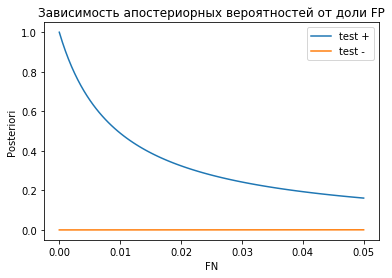

In [4]:
plt.plot(p2, var_p2_pos_test)
plt.plot(p2, var_p2_neg_test)
plt.title("Зависимость апостериорных вероятностей от доли FP")
plt.xlabel("FN")
plt.ylabel("Posteriori")
plt.legend(['test +', 'test -']);

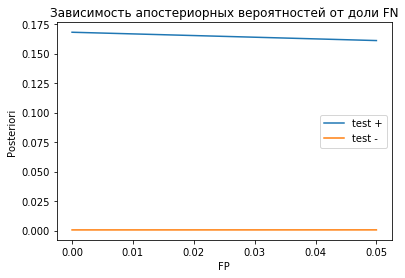

In [5]:
plt.plot(p1, var_p1_pos_test)
plt.plot(p1, var_p1_neg_test)
plt.title("Зависимость апостериорных вероятностей от доли FN")
plt.xlabel("FP")
plt.ylabel("Posteriori")
plt.legend(['test +', 'test -']);

Судя по графикам (и анализируя формулу) можно сделать вывод, что важнее оптимизировать FP, то есть нужно снижать долю ложно положительных тестов

## Часть II: О линейной регрессии

Скачаем данные и выделим 50 дней заболеваемости в России

In [6]:
data = pd.read_csv('owid-covid-data.csv')
data['date'] = data.date.apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
data['new_cases'] = data.new_cases.apply(lambda s: s if s > 0 else 1)
rus_train = data[(data.location == 'Russia')&(data.date >= date(2020, 3, 3))].sort_values('date').head(50)
rus_train.reset_index(drop=True, inplace=True)
rus_train['day'] = rus_train.date.apply(lambda s: (s - date(2020, 3, 2)).days)

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


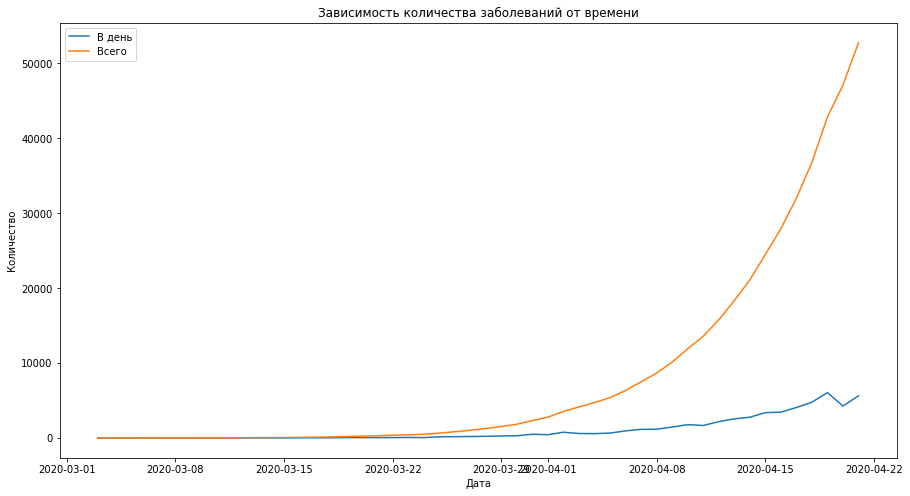

In [7]:
plt.figure(figsize=figsize)
plt.plot(rus_train.date, rus_train.new_cases)
plt.plot(rus_train.date, rus_train.total_cases)
plt.title("Зависимость количества заболеваний от времени")
plt.xlabel("Дата")
plt.ylabel("Количество")
plt.legend(['В день', 'Всего']);

In [8]:
N = 1000
xs = np.linspace(0,100, N)

Обучим линейную регрессию и найдем стандартное отклонение в данных как std предсказаний и истинными значениями

In [9]:
model = LinearRegression()
model.fit(rus_train.day.values.reshape(-1, 1), np.log(rus_train.total_cases))
y_pred_log = model.predict(rus_train.day.values.reshape(-1, 1))
data_sigm = np.std(y_pred_log - np.log(rus_train.total_cases))
data_sigm

0.3490422059635659

In [10]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])

In [11]:
def bayesian_update(mu, sigma, x, y, sigma_noise=data_sigm):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

Построим апостериорное распределение последовательно для каждой точки

In [12]:
for i in range(rus_train.shape[0]):
    px = rus_train.loc[i, 'day']
    py = np.log(rus_train.loc[i, 'total_cases'])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)

Посэмплируем и порисуем экспоненты

In [13]:
def myplot_sample_lines(mu, sigma, n=20, points=None):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    for w in my_w:
        plt.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)

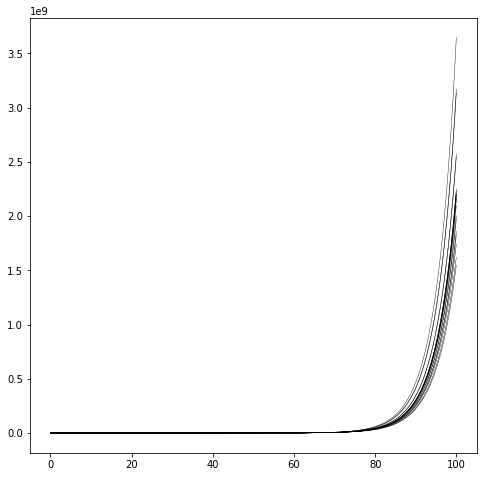

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
myplot_sample_lines(cur_mu, cur_sigma, 20)

Посэмплируем экспоненты и выдадим статистики по предсказаниям

In [15]:
x_1 = (date(2020, 5, 1) - date(2020, 3, 3)).days # 1 мая
x_2 = (date(2020, 6, 1) - date(2020, 3, 3)).days # 1 июня
x_3 = (date(2020, 9, 1) - date(2020, 3, 3)).days # 1 сентября

In [16]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    y_1 = []
    y_2 = []
    y_3 = []
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
        y_1.append(np.exp(w[1]*x_1 + w[0]))
        y_2.append(np.exp(w[1]*x_2 + w[0]))
        y_3.append(np.exp(w[1]*x_3 + w[0]))
    return res, [np.median(np.array(y_1)), np.median(np.array(y_2)), np.median(np.array(y_3))]

In [17]:
# Нарисуем результат
def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.plot(xs, np.exp(mu[1]*xs + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(mu[1]*xs + mu[0] - data_sigm), np.exp(mu[1]*xs + mu[0] + data_sigm),  alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.exp(np.mean(x, axis=0) - np.std(x, axis=0)), np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), alpha=.2, label="+- дисперсия предсказаний")
    ax.legend()

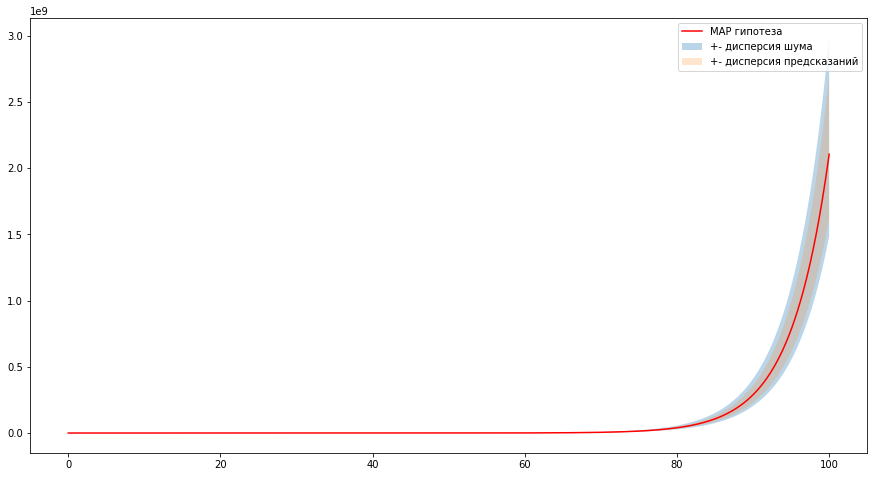

In [18]:
x, pred = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
plot_predictions(xs, cur_mu, x)

По получившимся значениям можно сделать вывод, что экспонента не подходит для прогнозироания пандемии

In [19]:
print("Количество заболевших к 1 мая: {0}".format(int(pred[0])))
print("Количество заболевших к 1 июня: {0}".format(int(pred[1])))
print("Количество заболевших к 1 сентября: {0}".format(int(pred[2])))

Количество заболевших к 1 мая: 613629
Количество заболевших к 1 июня: 288790836
Количество заболевших к 1 сентября: 24797884775999964


Если общее количество заразившихся распределено как функция распределения для гауссиана, то будем считать, что количество заразившихся в день распределено как функция плотности распределения. Константу перед экспонентой заведем в степень

In [20]:
cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

In [21]:
def bayesian_update(mu, sigma, x, y, sigma_noise=data_sigm):
    x_matrix = np.array([[1, x, x*x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [22]:
for i in range(rus_train.shape[0]):
    px = rus_train.loc[i, 'day']
    py = np.log(rus_train.loc[i, 'new_cases'])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, px, py)

То, что коэффициент при страшем члене отрицательный означает, что значения ограничены серху

In [28]:
cur_mu

array([-0.6658629 ,  0.27862826, -0.00181894])

In [23]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2]*xs*xs
    return res

Чтобы получить опять общее количество заразившихся к дате, будем суммиовать все предыдущие дни

In [24]:
# Нарисуем результат
def plot_predictions(xs, mu, x):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ys = [mu[2]*mu[2]*xs[0] + mu[1]*xs[0] + mu[0]]
    for x_i in xs[1:]:
        y_i = mu[2]*mu[2]*x_i + mu[1]*x_i + mu[0]
        ys.append(ys[-1] + y_i)
    ys = np.array(ys)
    ax.plot(xs, np.exp(ys), color="red", label="MAP гипотеза")
    ax.fill_between(xs, np.exp(ys - data_sigm), np.exp(ys + data_sigm), alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.exp(np.mean(x, axis=0) - np.std(x, axis=0)), np.exp(np.mean(x, axis=0) + np.std(x, axis=0)), alpha=.2, label="+- дисперсия предсказаний")
    ax.legend()
    return ys

In [25]:
N = 51
xs = np.linspace(0, 50, N)

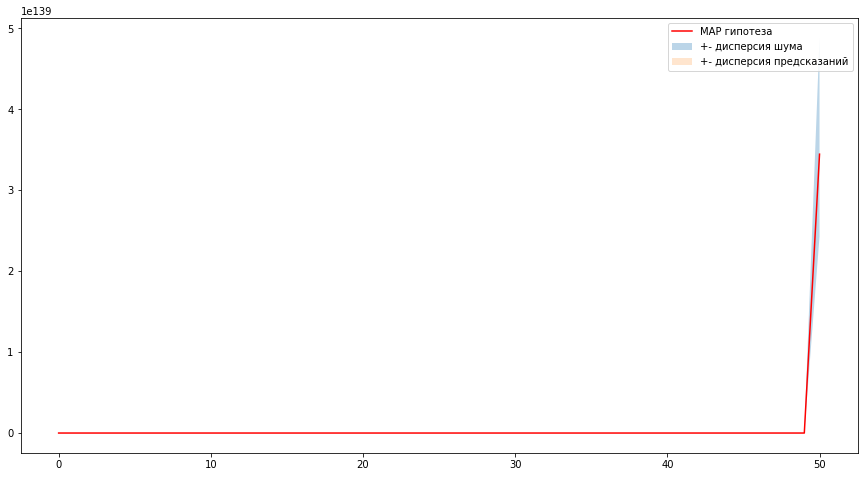

In [26]:
x = sample_statistics(cur_mu, cur_sigma, xs, n=1000)
ys = plot_predictions(xs, cur_mu, x)

Числа получились гигантские, из чего можно сделать вывод, что я не понимаю как обучать сигмоиду :(